C:\Users\MIran\anaconda3-2\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:02:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\MIran\anaconda3-2\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:02:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\MIran\anaconda3-2\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:02:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\MIran\anaconda3-2\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:02:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up


Classification Report (threshold=0.4):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     23057
           1       0.75      0.18      0.29      1367

    accuracy                           0.95     24424
   macro avg       0.85      0.59      0.63     24424
weighted avg       0.94      0.95      0.94     24424


Confusion Matrix:
[[22976    81]
 [ 1122   245]]
ROC AUC: 0.8429523550601465
✅ Model trained with class weighting only (no resampling). Metrics saved.


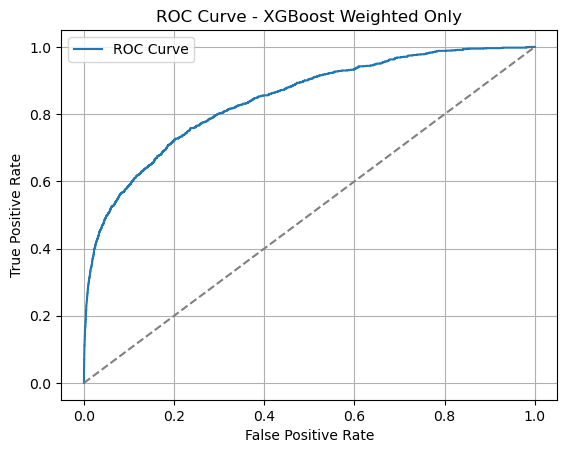

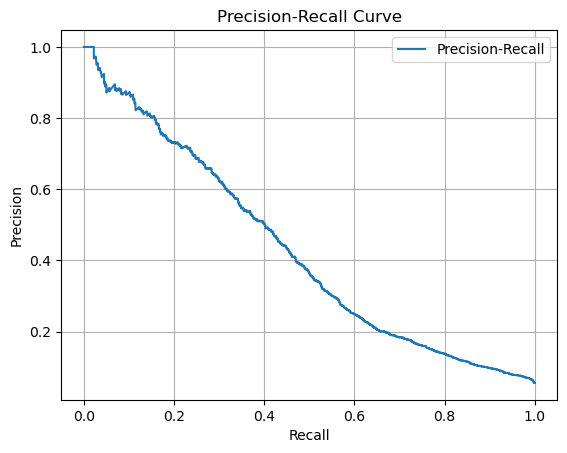

In [8]:
# File: train_model.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib

# Load dataset
df = pd.read_csv("cleaned_songs.csv")
df["popular"] = (df["popularity"] >= 70).astype(int)

FEATURES = [
    "danceability", "energy", "valence",
    "speechiness", "acousticness", "tempo", "duration"
]

X = df[FEATURES]
y = df["popular"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute sample weights from imbalanced y_train
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Train XGBoost with sample weights
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Calibrate
calibrated_xgb = CalibratedClassifierCV(estimator=xgb, method="sigmoid", cv=3)
calibrated_xgb.fit(X_train_scaled, y_train)

# Save
joblib.dump(calibrated_xgb, "model_xgb.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(FEATURES, "features.pkl")

# Evaluate
proba = calibrated_xgb.predict_proba(X_test_scaled)[:, 1]
preds = (proba >= 0.4).astype(int)
print("\nClassification Report (threshold=0.4):")
print(classification_report(y_test, preds))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, proba))

# ROC
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - XGBoost Weighted Only")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend()
plt.savefig("roc_curve_weight_only.png")

# PR
prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(rec, prec, label="Precision-Recall")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend()
plt.savefig("pr_curve_weight_only.png")

print("✅ Model trained with class weighting only (no resampling). Metrics saved.")